# Variability analysis

An important step in computational modelling is the analysis of the sensitivity of model results to parameter changes. Metabolic Control Analysis (MCA) provides tools for analyzing the effects of such changes on the steady state of the model.

In [1]:
from __future__ import print_function, division
%matplotlib inline

import roadrunner
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt

In [2]:
"""
import roadrunner
print(roadrunner.__version__)
!wget https://raw.githubusercontent.com/matthiaskoenig/multiscale-galactose/develop/python/multiscalepy/multiscale/examples/models/demo/Koenig_demo_10_annotated.xml -O test.xml

# issue #268
roadrunner.Config.setValue(roadrunner.Config.LOADSBMLOPTIONS_CONSERVED_MOIETIES, True)
r = roadrunner.RoadRunner("test.xml")

# issue #267
r = roadrunner.RoadRunner("https://raw.githubusercontent.com/matthiaskoenig/multiscale-galactose/develop/python/multiscalepy/multiscale/examples/models/demo/Koenig_demo_10_annotated.xml")
"""


'\nimport roadrunner\nprint(roadrunner.__version__)\n!wget https://raw.githubusercontent.com/matthiaskoenig/multiscale-galactose/develop/python/multiscalepy/multiscale/examples/models/demo/Koenig_demo_10_annotated.xml -O test.xml\n\n# issue #268\nroadrunner.Config.setValue(roadrunner.Config.LOADSBMLOPTIONS_CONSERVED_MOIETIES, True)\nr = roadrunner.RoadRunner("test.xml")\n\n# issue #267\nr = roadrunner.RoadRunner("https://raw.githubusercontent.com/matthiaskoenig/multiscale-galactose/develop/python/multiscalepy/multiscale/examples/models/demo/Koenig_demo_10_annotated.xml")\n'

We are interested in the effects of parameters for a given simulation scenario. The analysed scenario is simple simulation to steady state.

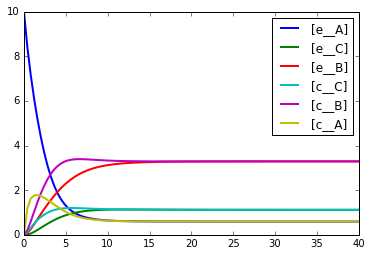

e__A = 0.591981879199
e__C = 1.11846281737
e__B = 3.28943421977
c__C = 1.11846247041
c__B = 3.28953580205
c__A = 0.592148052084


In [3]:
# from multiscale.examples.testdata import demo_filepath
from multiscale.examples.testdata import demo_sbml

# equidistant timecourse
# roadrunner.Config.setValue(roadrunner.Config.LOADSBMLOPTIONS_CONSERVED_MOIETIES, True)
roadrunner.Config.setValue(roadrunner.Config.LOADSBMLOPTIONS_CONSERVED_MOIETIES, False)
r = roadrunner.RoadRunner(demo_sbml)
s = r.simulate(0, 40, 100, plot=True)  

for sid, value in zip(r.model.getFloatingSpeciesIds(), r.model.getFloatingSpeciesConcentrations()):
    print('{} = {}'.format(sid, value))

In [4]:
# Steady States
# Performs a steady state calculation (evolves the system to a steady
#        state), then calculates and returns the set of values specified by
#        the steady state selections.
# [issue #258 https://github.com/sys-bio/roadrunner/issues/258]
print(r.steadyStateSelections)
print(r.getSteadyStateValues())

['[e__A]', '[e__C]', '[e__B]', '[c__C]', '[c__B]', '[c__A]']
[ 0.59374325  1.12151407  3.29857067  1.12151407  3.29857078  0.59374274]


In [5]:
# The steady state fluxes are
print(r.model.getReactionIds())
print(r.getReactionRates())

['bA', 'bB', 'bC', 'v1', 'v2', 'v3', 'v4']
[  1.15539990e-12   3.30439930e-14   9.84928341e-17   2.63885663e-07
   2.96871371e-07   5.60757033e-07  -2.63885663e-07]


## Metabolic Control Analysis (MCA)

Metabolic control analysis (MCA) is a mathematical framework for describing metabolic, signaling, and genetic pathways. MCA quantifies how variables, such as fluxes and species concentrations, depend on network parameters. In particular it is able to describe how network dependent properties, called control coefficients, depend on local properties called elasticities [http://en.wikipedia.org/wiki/Metabolic_control_analysis].

For the available functions in roadrunner see
https://sys-bio.github.io/roadrunner/python_docs/metabolic.html

### Control Coefficients

A control coefficient measures the relative steady state change in a system variable, e.g. pathway flux (J) or metabolite concentration (S), in response to a relative change in a parameter, e.g. enzyme activity or the steady-state rate ( v_i ) of step i. The two main control coefficients are the flux and concentration control coefficients. Flux control coefficients are defined by:

$$C^J_{v_i} = \left( \frac{dJ}{dp} \frac{p}{J} \right) \bigg/ \left( \frac{\partial v_i}{\partial p}\frac{p}{v_i} \right) = \frac{d\ln J}{d\ln v_i}$$

In [6]:
# Scaled control coefficient with respect to a global parameter.
r.getCC('bA', 'Vmax_bA')

0.3041219359886312

In [7]:
# The n by n matrix of scaled flux control coefficients 
# where n is the number of reactions.

# [issue #251 https://github.com/sys-bio/roadrunner/issues/251]
print('** Scaled Flux Control Coefficients **')
r.getScaledFluxControlCoefficientMatrix()
C_J = DataFrame(rr.getScaledFluxControlCoefficientMatrix(), \
                index=r.model.getReactionIds(), \
                columns=r.model.getReactionIds())
print(C_J)

** Scaled Flux Control Coefficients **


RuntimeError: Unexpected error from getScaledFluxControlCoefficientMatrix(): Dividing with zero

and concentration control coefficients by:

$$C^S_{v_i} = \left( \frac{dS}{dp} \frac{p}{S} \right) \bigg/ \left( \frac{\partial v_i}{\partial p} \frac{p}{v_i} \right) = \frac{d\ln S}{d\ln v_i}$$

In [8]:
# The m by n matrix of scaled concentration control coefficients where m is the number
# of floating species and n the number of reactions.
print('** Scaled Concentration Control Coefficients **')
C_S = DataFrame(r.getScaledConcentrationControlCoefficientMatrix(), \
                index=r.model.getFloatingSpeciesIds(), \
                columns=r.model.getReactionIds())
print(C_S)

** Scaled Concentration Control Coefficients **
      bA  bB  bC        v1        v2        v3        v4
e__A  -0  -0  -0 -0.292398 -0.223684  0.422515  0.093567
e__C   0  -0   0 -0.030960  0.188080 -0.355263  0.198142
e__B   0   0  -0  0.063158 -0.023684  0.044737 -0.084211
c__C   0  -0  -0 -0.030960  0.188080 -0.355263  0.198142
c__B   0  -0  -0  0.063158 -0.023684  0.044737 -0.084211
c__A   0  -0  -0 -0.292398 -0.223684  0.422515  0.093567


### Summation Theorems

The flux control summation theorem was discovered independently by the Kacser/Burns group and the Heinrich/Rapoport group in the early 1970s and late 1960s. The flux control summation theorem implies that metabolic fluxes are systemic properties and that their control is shared by all reactions in the system. When a single reaction changes its control of the flux this is compensated by changes in the control of the same flux by all other reactions.

$$\sum_i C^J_{v_i} = 1$$

$$\sum_i C^S_{v_i} = 0$$

In [9]:
# Flux control coefficients have to sum to 1
print(np.sum(C_J, axis=1))
abs(np.sum(C_J, axis=1)-1) < 1E-6

NameError: name 'C_J' is not defined

In [10]:
# Concentration control coefficients have to sum to 0
print(np.sum(C_S, axis=1))
np.sum(C_S, axis=1) < 1E-6

e__A    2.775558e-17
e__C    2.775558e-17
e__B   -1.387779e-17
c__C    2.775558e-17
c__B   -1.387779e-17
c__A    1.387779e-17
dtype: float64


e__A    True
e__C    True
e__B    True
c__C    True
c__B    True
c__A    True
dtype: bool

### Elasticity coefficients
Retrieve a single elasticity coefficient with respect to a global parameter.

        For example::

          x = rr.getEE ('J1', 'Vmax')

In [11]:
print(r.model.getGlobalParameterIds())
print(r.getEE('v1', 'Vmax_v1'))
print(r.getEE('v1', 'Keq_v1'))

['Km_C', 'scale_f', 'Vmax_bB', 'Vmax_bC', 'Vmax_bA', 'Vmax_v2', 'Vmax_v3', 'Vmax_v1', 'Km_A', 'Vmax_v4', 'Km_B', 'Keq_v4', 'Keq_v1']
1.0
1.24996835523
